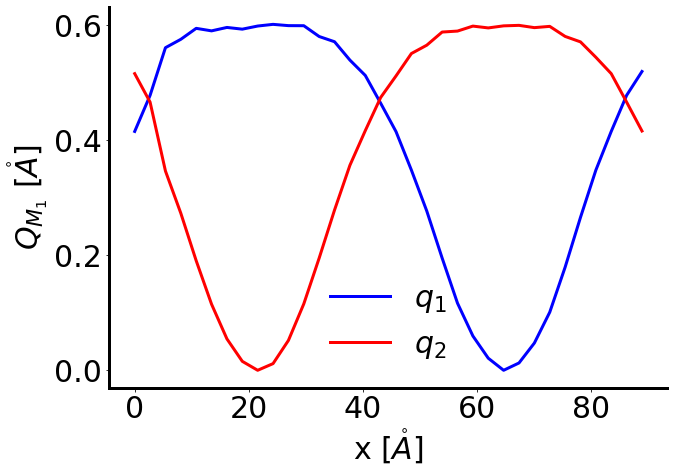

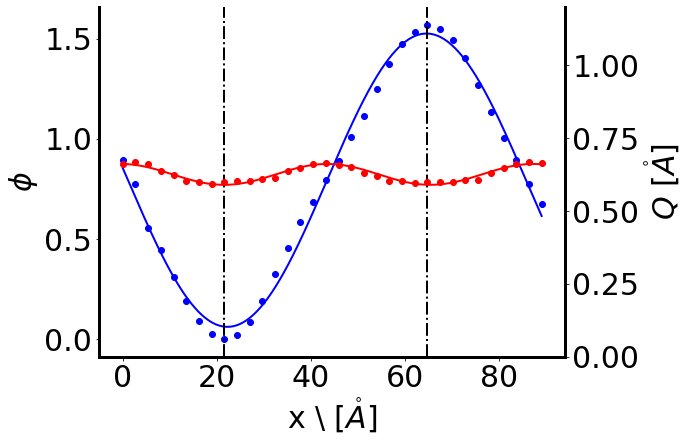

In [14]:
import requests
import re
import sys
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import scipy as sc
from scipy import optimize


%matplotlib inline

#_____________________________________________________________________________________________#

#function that will submit a parent and a child cif to ISODISTORT. You can specify if you want to choose the 
#possible bases during runtime or if you want to use a predetermined basis. The basis needs to have the following syntax:
#"x1 y1 z1 x2 y2 z2 x3 y3 z3 t" i.e. the first 3 numbers correspond to the first basis vector etc.
#The output will be the final html file
def submit_isodistort(_parent_cif, _child_cif, basis_prompt = True, _basis = ""):
    #php urls
    upload_php = "https://stokes.byu.edu/iso/isodistortuploadfile.php"
    form_php = "https://stokes.byu.edu/iso/isodistortform.php"
    
    #prepare the POST parameters for the upload of the parent cif
    parameters = {'input':'uploadparentcif'}
    
    #upload the parent cif file
    file = open(_parent_cif,'rb')
    upload = requests.post(upload_php, data = parameters, files={"toProcess":file})
    
    #get the name of the temporary parent file
    temp_file = re.search(r'VALUE=\"/tmp(.*)', upload.text)[0]
    temp_file = temp_file[:-2]
    temp_file = temp_file[7:]
    
    #submit the temporary parent cif to the form
    parameters = {'filename': temp_file, 'input': 'uploadparentcif'}
    form = requests.post(form_php, data = parameters)
    
    #get the names of the necessary hidden values of the parent cif
    hidden_values = re.findall(r'hidden(.*)', form.text)
    num_of_values = len(hidden_values)
    value_names = [""] * num_of_values
    value_values = [""] * num_of_values
    start_index = 0;
    end_index = 0;
    
    #the relevant parameters are located after the uploadsubgroupcif input specification
    for i in range(0, len(hidden_values)):
        value_names[i] = hidden_values[i].split('"')[2]
        value_values[i] = hidden_values[i].split('"')[4]
        if value_values[i] == "uploadsubgroupcif":
            start_index = i
        elif value_values[i] == "changesearch" and start_index != 0 and i > start_index:
            end_index = i-1
    
    #prepare the POST parameters for the upload of the child cif (these are the parameters of the parent cif)
    parameters = {}
    for i in range(start_index, end_index):
        parameters[str(value_names[i])] = str(value_values[i])
    
    #upload parent and child cif (the parent as parameters, the child as file)
    file = open(_child_cif,'rb')
    upload = requests.post(upload_php, data = parameters, files={"toProcess":file})
    
    #get the name of the temporary child file
    temp_file = re.search(r'VALUE=\"/tmp(.*)', upload.text)[0]
    temp_file = temp_file[:-2]
    temp_file = temp_file[7:]
    
    #give the temporary child file name as an additional parameter
    parameters['filename'] = temp_file
    
    #submit the parent and child cif to the form (the parent as parameters, the child as temporary file)
    form = requests.post(form_php, data = parameters)
    
    bases = re.search(r'\"basisselect\"((.|\n)*?)<br>', form.text)[0]
    #get the number of bases
    num_of_bases = int(bases.count('OPTION') / 2 - 1)
       
        
    #get the basis index if prompting
    if basis_prompt:
        #first print all bases
        for i in range(0, num_of_bases):
            _basis = re.findall(r'VALUE=(.*)', bases)[i]
            _basis = _basis.split("\"")[1]
            print("Basis " + str(i+1) + ": " + str(_basis)) 
        #prompt index
        basis_number = int(input("Enter basis number: ")) 
        if num_of_bases < _basis_number:
            sys.exit("You have chosen basis number " + str(_basis_number) + " but there are only " + str(num_of_bases) + " bases.")
        
        _basis = re.findall(r'VALUE=(.*)', bases)[basis_number - 1]
        _basis = _basis.split("\"")[1]
        print("Chosen basis: " + str(_basis))
    
    
    #get the necessary hidden values again
    hidden_values = re.findall(r'hidden(.*)', form.text)
    num_of_values = len(hidden_values)
    value_names = [""] * num_of_values
    value_values = [""] * num_of_values
    
    for i in range(0, len(hidden_values)):
        value_names[i] = hidden_values[i].split('"')[2]
        value_values[i] = hidden_values[i].split('"')[4]
    
    #get the necessary hidden values again
    parameters = {}
    for i in range(0, len(hidden_values)):
        parameters[str(value_names[i])] = str(value_values[i])

    #add the basis to the parameters
    parameters['basisselect'] = _basis
    
    #set the remaining parameters to the default values
    parameters['basis11'] = '1'
    parameters['basis12'] = '0'
    parameters['basis13'] = '0'
    parameters['basis21'] = '0'
    parameters['basis22'] = '1'
    parameters['basis23'] = '0'
    parameters['basis31'] = '0'
    parameters['basis32'] = '0'
    parameters['basis33'] = '1'
    parameters['chooseorigin'] = 'false'
    parameters['dmax'] = '1'
    parameters['includestrain'] = 'true'
    parameters['inputbasis'] = 'list'
    parameters['origin1'] = '0'
    parameters['origin2'] = '0'
    parameters['origin3'] = '0'
    parameters['trynearest'] = 'true'
        
    #submit the distort input to the form
    form = requests.post(form_php, data = parameters)
    
    if re.search("Wyckoff positions in parent are not compatible with Wyckoff positions in subgroup", form.text):
        sys.exit("Wyckoff positions in parent are not compatible with Wyckoff positions in subgroup")
    
    if re.search("Subgroup and basis vectors are not compatible with parent.", form.text):
        sys.exit("Subgroup and basis vectors are not compatible with parent.")     
        
    #amplitudes can already be found in this html. No need for mode display submission
    return form.text

#extract the amplitude of a certain mode and irreducible represenation from the final html file. 
def extract_amplitude(_out_html, _irrep, _disp, _abs = True):
    #escape brackets in the displacements
    _disp = _disp.replace('(', '\\(')
    _disp = _disp.replace(')', '\\)')
    _disp = _disp.replace('[', '\\[')
    _disp = _disp.replace(']', '\\]')
    #escape regex metachars
    _irrep = _irrep.replace('+', '\\+')
    _irrep = _irrep.replace('-', '\\-')
    _irrep = _irrep.replace('*', '\\*')
    _disp = _disp.replace('+', '\\+')
    _disp = _disp.replace('-', '\\-')
    _disp = _disp.replace('*', '\\*')
    #search for the specified irrep
    irrep_pattern = '' + _irrep + '\\s' + '(.|\\n)*?<p>'
    irrep_data = re.search(irrep_pattern, _out_html)
    if irrep_data == None:
        sys.exit("irrep not present")
    #search the displacements in the irrep data
    disp_pattern = '(.*)' + _disp
    disp_data = re.search(disp_pattern, irrep_data[0])
    if irrep_data == None:
        sys.exit("displacement not present")
    amplitude = float(disp_data[0].split("\"")[5])
    if _abs:
        amplitude = abs(amplitude)
    return amplitude   
    
#_____________________________________________________________________________________________#


parent_cif = "../BULK/P4ncc_LDA_VASP.cif"

basis1 = "2 0 0 0 2 0 0 0 1 1"
basis2 = "1 1 -1 1 1 1 1 -1 0 1"
basis3 = "-1 1 1 1 -1 1 1 1 0 1"

basis = basis1
nuc = 32

#calculate the amplitudes by submitting to isodistort
isodistort = False

#extract the amplitudes of all irreps of the M1 mode in both directions (a and b)
if isodistort:
    Q_fixed = np.zeros((nuc, 16))
    for i in range(1, nuc+1):
        child_cif = "BETA_FIXED/UCS/UC" + str(i) + ".cif"
        out_html = submit_isodistort(parent_cif, child_cif, False, basis)
        
        Q_fixed[i-1, 0] = extract_amplitude(out_html, "M1", "[W1:c:dsp]E*_1(a)")
        Q_fixed[i-1, 1] = extract_amplitude(out_html, "M1", "[W1:c:dsp]E*_1(b)")
        Q_fixed[i-1, 2] = extract_amplitude(out_html, "M1", "[W1:c:dsp]E*_2(a)")
        Q_fixed[i-1, 3] = extract_amplitude(out_html, "M1", "[W1:c:dsp]E*_2(b)")
        Q_fixed[i-1, 4] = extract_amplitude(out_html, "M1", "[O1:c:dsp]E*_1(a)")
        Q_fixed[i-1, 5] = extract_amplitude(out_html, "M1", "[O1:c:dsp]E*_1(b)")
        Q_fixed[i-1, 6] = extract_amplitude(out_html, "M1", "[O1:c:dsp]E*_2(a)")
        Q_fixed[i-1, 7] = extract_amplitude(out_html, "M1", "[O1:c:dsp]E*_2(b)")
        Q_fixed[i-1, 8] = extract_amplitude(out_html, "M1", "[O2:f:dsp]B_1(a)")
        Q_fixed[i-1, 9] = extract_amplitude(out_html, "M1", "[O2:f:dsp]B_1(b)")
        Q_fixed[i-1, 10] = extract_amplitude(out_html, "M1", "[O2:f:dsp]B_2(a)")
        Q_fixed[i-1, 11] = extract_amplitude(out_html, "M1", "[O2:f:dsp]B_2(b)")
        Q_fixed[i-1, 12] = extract_amplitude(out_html, "M1", "[O2:f:dsp]B_3(a)")
        Q_fixed[i-1, 13] = extract_amplitude(out_html, "M1", "[O2:f:dsp]B_3(b)")
        Q_fixed[i-1, 14] = extract_amplitude(out_html, "M1", "[O2:f:dsp]B_4(a)")
        Q_fixed[i-1, 15] = extract_amplitude(out_html, "M1", "[O2:f:dsp]B_4(b)")
        print("fixed: %d" %(i))
    
    Q_free = np.zeros((nuc, 16))
    for i in range(1, nuc+1):
        child_cif = "BETA_FREE/UCS/UC" + str(i) + ".cif"
        out_html= submit_isodistort(parent_cif, child_cif, False, basis)
        
        Q_free[i-1, 0] = extract_amplitude(out_html, "M1", "[W1:c:dsp]E*_1(a)")
        Q_free[i-1, 1] = extract_amplitude(out_html, "M1", "[W1:c:dsp]E*_1(b)")
        Q_free[i-1, 2] = extract_amplitude(out_html, "M1", "[W1:c:dsp]E*_2(a)")
        Q_free[i-1, 3] = extract_amplitude(out_html, "M1", "[W1:c:dsp]E*_2(b)")
        Q_free[i-1, 4] = extract_amplitude(out_html, "M1", "[O1:c:dsp]E*_1(a)")
        Q_free[i-1, 5] = extract_amplitude(out_html, "M1", "[O1:c:dsp]E*_1(b)")
        Q_free[i-1, 6] = extract_amplitude(out_html, "M1", "[O1:c:dsp]E*_2(a)")
        Q_free[i-1, 7] = extract_amplitude(out_html, "M1", "[O1:c:dsp]E*_2(b)")
        Q_free[i-1, 8] = extract_amplitude(out_html, "M1", "[O2:f:dsp]B_1(a)")
        Q_free[i-1, 9] = extract_amplitude(out_html, "M1", "[O2:f:dsp]B_1(b)")
        Q_free[i-1, 10] = extract_amplitude(out_html, "M1", "[O2:f:dsp]B_2(a)")
        Q_free[i-1, 11] = extract_amplitude(out_html, "M1", "[O2:f:dsp]B_2(b)")
        Q_free[i-1, 12] = extract_amplitude(out_html, "M1", "[O2:f:dsp]B_3(a)")
        Q_free[i-1, 13] = extract_amplitude(out_html, "M1", "[O2:f:dsp]B_3(b)")
        Q_free[i-1, 14] = extract_amplitude(out_html, "M1", "[O2:f:dsp]B_4(a)")
        Q_free[i-1, 15] = extract_amplitude(out_html, "M1", "[O2:f:dsp]B_4(b)")
        print("free: %d" % (i))

Q_fixed_temp = np.copy(Q_fixed)  
Q_free_temp = np.copy(Q_free) 
    
#calculate the total amplitude components a and b of mode M1
q1_fixed = np.sqrt(np.power(Q_fixed_temp[:,0],2) + np.power(Q_fixed_temp[:,2],2) + np.power(Q_fixed_temp[:,4],2) + np.power(Q_fixed_temp[:,6],2) \
     + np.power(Q_fixed_temp[:,8],2) + np.power(Q_fixed_temp[:,10],2) + np.power(Q_fixed_temp[:,12],2) + np.power(Q_fixed_temp[:,14],2))
q2_fixed = np.sqrt(np.power(Q_fixed_temp[:,1],2) + np.power(Q_fixed_temp[:,3],2) + np.power(Q_fixed_temp[:,5],2) + np.power(Q_fixed_temp[:,7],2) \
     + np.power(Q_fixed_temp[:,9],2) + np.power(Q_fixed_temp[:,11],2) + np.power(Q_fixed_temp[:,13],2) + np.power(Q_fixed_temp[:,15],2))

q1_free = np.sqrt(np.power(Q_free_temp[:,0],2) + np.power(Q_free_temp[:,2],2) + np.power(Q_free_temp[:,4],2) + np.power(Q_free_temp[:,6],2) \
     + np.power(Q_free_temp[:,8],2) + np.power(Q_free_temp[:,10],2) + np.power(Q_free_temp[:,12],2) + np.power(Q_free_temp[:,14],2))
q2_free = np.sqrt(np.power(Q_free_temp[:,1],2) + np.power(Q_free_temp[:,3],2) + np.power(Q_free_temp[:,5],2) + np.power(Q_free_temp[:,7],2) \
     + np.power(Q_free_temp[:,9],2) + np.power(Q_free_temp[:,11],2) + np.power(Q_free_temp[:,13],2) + np.power(Q_free_temp[:,15],2))

plt.rcParams.update({'font.size': 30})

#add some points
q1_fixed = np.insert(q1_fixed, 0, q1_fixed[q1_fixed.size-2])
q2_fixed = np.insert(q2_fixed, 0, q2_fixed[q2_fixed.size-2])
q1_fixed = np.insert(q1_fixed, 0, q1_fixed[q1_fixed.size-3])
q2_fixed = np.insert(q2_fixed, 0, q2_fixed[q2_fixed.size-3])
#
#
#q1_free = np.insert(q1_free, 0, q1_free[q1_free.size-2])
#q2_free = np.insert(q2_free, 0, q2_free[q2_free.size-2])
#q1_free = np.insert(q1_free, 0, q1_free[q1_free.size-3])
#q2_free = np.insert(q2_free, 0, q2_free[q2_free.size-3])

x_fixed = np.linspace(0,  83.737472 + 2*83.737472/nuc, nuc + 2)
x_free = np.linspace(0,  83.737472, nuc)

#plotting q1 and q2
plt.figure(1, figsize=[10,7])
plt.plot(x_fixed, q1_fixed/2, label=r'$q_1$', linewidth=3, color='blue')
plt.plot(x_fixed, q2_fixed/2, label=r'$q_2$', linewidth=3, color='red')
#plt.plot(x_free, q1_free, label=r'$q_1^{free}$', linewidth=3, color='blue', linestyle='-.')
#plt.plot(x_free, q2_free-0.06, label=r'$q_2^{free}$', linewidth=3, color='red', linestyle='-.')
plt.legend(frameon=False)
#plt.legend(frameon=False, bbox_to_anchor=(0.84,0.75), handlelength=1.5)
plt.xlabel(r'x $[\mathring{A}]$')
plt.ylabel(r'$Q_{M_1}$ $[\mathring{A}]$')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)


#plotting phi and q
q = np.sqrt((q1_fixed/2)**2 + (q2_fixed/2)**2)
q0 = q[8]
phi = np.arccos(q1_fixed/(2*q))

def sin_poly(x, a, b, c, d):
    return a + b*np.sin(c*x-d)

p = [0.5, 0.5, 0.1, 0]
popt_phi, pcov_phi= sc.optimize.curve_fit(sin_poly, x_fixed, phi/(np.pi/2), p0=p) 

p = [1, 0.05, 0.1, 10]
popt_q, pcov_q= sc.optimize.curve_fit(sin_poly, x_fixed, q/q0, p0=p)


plt.figure(2, figsize=[10, 7])
ax = plt.gca()
ax2 = ax.twinx()

ax.scatter(x_fixed, phi, color="blue")
ax.plot(np.linspace(0,x_fixed[-1],1000), sin_poly(np.linspace(0,x_fixed[-1],1000), *popt_phi)*(np.pi/2), color="blue", linewidth=2)
ax2.scatter(x_fixed, q, color="red")
ax2.plot(np.linspace(0,x_fixed[-1],1000), sin_poly(np.linspace(0,x_fixed[-1],1000), *popt_q)*q0, color="red", linewidth=2)

ax.axvline(x=x_fixed[8],linewidth=2, color='k', linestyle='-.')
ax.axvline(x=x_fixed[24],linewidth=2, color='k', linestyle='-.')

ax.set_xlabel(r'x \ $[\mathring{A}]$')
ax.set_ylabel(r'$\phi$')
ax2.set_ylabel(r'$Q \ [\mathring{A}]$')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_linewidth(3)

ax2.set_ylim([0,1.2])


plt.tight_layout()
plt.savefig("DW_BB.eps")
